In [46]:
import scprep, scipy, graphtools, leidenalg, phate, magic
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import scale
from scipy import io
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt

In [38]:
sdata = sc.read_h5ad('../data/processed_files/3_human_all_cell_types_all_genes.h5ad')

## Leiden clustering

In [14]:
G = graphtools.Graph(sdata.obsm["X_pca"], use_pygsp=True, n_pca=None, 
                     random_state=42, sample_idx=sdata.obs.batch, bandwidth_scale=0.5)

In [15]:
partition = leidenalg.find_partition(G.to_igraph(), leidenalg.RBConfigurationVertexPartition, seed=2,
                                     weights="weight", resolution_parameter=res, n_iterations=-1)
sdata.obs[f"clusters_res_0.1"] = np.array(partition.membership).astype('str')

In [18]:
sdata.obs[f'clusters_res_0.1'] = scprep.utils.sort_clusters_by_values(sdata.obs[f'clusters_res_0.1'], -1*sdata.obsm['X_phate_mnn'][:, 0]).astype(str)
sdata.obs[f'clusters_res_0.1'] = (sdata.obs[f'clusters_res_0.1'].astype(int) + 1).astype(str)

<Axes: title={'center': 'Human all cells\nClusters'}, xlabel='PHATE1', ylabel='PHATE2'>

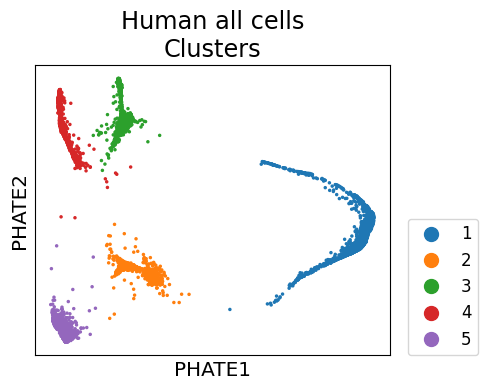

In [19]:
scprep.plot.scatter2d(sdata.obsm['X_phate_mnn'], c=sdata.obs[f'clusters_res_0.1'], legend_loc=(1.05,0), ticks=None,
                      label_prefix='PHATE', dpi=200, figsize=(5,4),  title='Human all cells\nClusters')

<Axes: title={'center': 'PTH'}, xlabel='PHATE1', ylabel='PHATE2'>

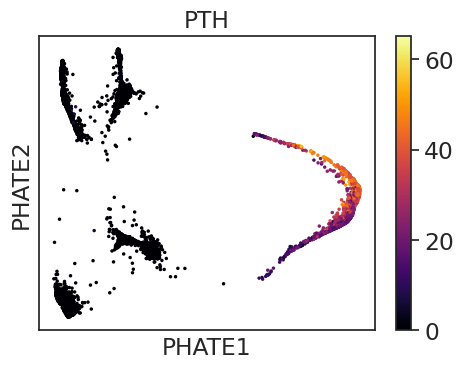

In [40]:
scprep.plot.scatter2d(sdata.obsm['X_phate_mnn'], c=sdata.to_df()['PTH'], legend_loc=(1.05,0), ticks=None,
                      label_prefix='PHATE', dpi=200, figsize=(5,4), filename='figures/human_all_cells/PTH.png', 
                      title='PTH')

## PyDESeq2

In [50]:
# DESeq operates on the raw measurements

sdata.layers['decontx'] = io.mmread('../data/intermediate_files/2_decontx_human_data.mtx').T
sdata.layers['decontx'] = scipy.sparse.csr_matrix(sdata.layers['decontx'])
sdata.layers['decontx'] = sdata.layers['decontx'].astype(int)

In [21]:
pbs = []
for sample in sdata.obs['sample'].unique():
    for cluster in sdata.obs['clusters_res_0.1'].unique():
        sdata_subset = sdata[sdata.obs['sample'] == sample]
        samp_cell_subset = sdata_subset[sdata_subset.obs['clusters_res_0.1'] == cluster]
        samp_cell_subset.X = samp_cell_subset.layers['decontx']

        rep_adata = sc.AnnData(X = samp_cell_subset.X.sum(axis=0), var=samp_cell_subset.var[[]])
        rep_adata.obs['sample'] = sample
        rep_adata.obs['cluster'] = int(cluster)
        pbs.append(rep_adata)

In [22]:
pb = sc.concat(pbs)
pb.obs_names = range(20)
counts = pd.DataFrame(pb.X, columns = pb.var_names)

for cluster in [1,2,3,4,5]:
    pb.obs[f'in_cluster_{cluster}_vs_1'] = pb.obs['cluster'].isin([cluster])
for sample in ['Y9', 'Y11', 'Y13']:
    pb.obs[f'in_sample_{sample}_vs_Y7'] = pb.obs['sample'].isin([sample])

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [25]:
for cluster in [1,2,3,4,5]:
    dds = DeseqDataSet(counts=counts, metadata=pb.obs, 
                   design_factors=[f'in_cluster_{cluster}_vs_1', 'in_sample_Y9_vs_Y7', 'in_sample_Y11_vs_Y7', 'in_sample_Y13_vs_Y7'])
    dds.deseq2()
    stat_res = DeseqStats(dds, n_cpus=8, contrast=(f'in-cluster-{cluster}-vs-1', 'True', 'False'))
    stat_res.summary()
    df = stat_res.results_df
    df = df[(df['log2FoldChange'] > 0) & (df['padj'] < 0.05)].sort_values('log2FoldChange', ascending=False)

    df.to_csv(f'results/human_all_cells/pseudobulk_cluster_{cluster}_vs_rest.csv')

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_438372/2448605613.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=counts, metadata=pb.obs,
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 107.38 seconds.

Fitting dispersion trend curve...
... done in 6.90 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in log
  results = super().__array_ufunc__(
Fitting MAP dispersions...
... done in 35.33 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/dds.py:69

Log2 fold change & Wald test p-value: in-cluster-1-vs-1 True vs False


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AL627309.1,0.001823,-3.686661,4.103422,-0.898436,0.368953,NaN
AL732372.1,0.054778,-1.034582,3.810584,-0.271502,0.786005,NaN
AC114498.1,0.000000,NaN,NaN,NaN,NaN,NaN
AL669831.5,0.113568,-2.769607,1.311687,-2.111484,0.034731,NaN
LINC00115,0.043505,-3.983678,3.631623,-1.096942,0.272667,NaN
...,...,...,...,...,...,...
AC007325.4,0.386248,3.051562,2.892638,1.054941,0.291452,NaN
AC007325.2,0.020292,-4.152903,4.147719,-1.001250,0.316706,NaN
AL354822.1,0.030971,-2.847292,3.932935,-0.723961,0.469090,NaN
AC004556.1,0.252070,-4.599317,4.161166,-1.105295,0.269032,NaN


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_438372/2448605613.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=counts, metadata=pb.obs,
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 25.77 seconds.

Fitting dispersion trend curve...
... done in 7.03 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in log
  results = super().__array_ufunc__(
Fitting MAP dispersions...
... done in 35.33 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/dds.py:695

Log2 fold change & Wald test p-value: in-cluster-2-vs-1 True vs False


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AL627309.1,0.001823,0.175342,4.102022,0.042745,0.965905,NaN
AL732372.1,0.054778,-0.031938,4.085559,-0.007817,0.993763,NaN
AC114498.1,0.000000,NaN,NaN,NaN,NaN,NaN
AL669831.5,0.113568,0.931645,1.639097,0.568389,0.569771,NaN
LINC00115,0.043505,-0.187261,3.556009,-0.052660,0.958002,NaN
...,...,...,...,...,...,...
AC007325.4,0.386248,-0.586339,3.449717,-0.169967,0.865036,NaN
AC007325.2,0.020292,0.010348,4.086052,0.002532,0.997979,NaN
AL354822.1,0.030971,-0.045140,4.082055,-0.011058,0.991177,NaN
AC004556.1,0.252070,0.070538,4.005531,0.017610,0.985950,NaN


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_438372/2448605613.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=counts, metadata=pb.obs,
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 23.89 seconds.

Fitting dispersion trend curve...
... done in 13.68 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in log
  results = super().__array_ufunc__(
Fitting MAP dispersions...
... done in 39.12 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/dds.py:69

Log2 fold change & Wald test p-value: in-cluster-3-vs-1 True vs False


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AL627309.1,0.001823,0.493234,4.099041,0.120329,0.904222,NaN
AL732372.1,0.054778,0.067780,4.073429,0.016639,0.986724,NaN
AC114498.1,0.000000,NaN,NaN,NaN,NaN,NaN
AL669831.5,0.113568,-0.027077,2.027673,-0.013354,0.989346,NaN
LINC00115,0.043505,0.121873,3.627522,0.033597,0.973199,NaN
...,...,...,...,...,...,...
AC007325.4,0.386248,-1.044604,3.469175,-0.301110,0.763330,NaN
AC007325.2,0.020292,0.326535,4.087261,0.079891,0.936324,NaN
AL354822.1,0.030971,0.275212,4.085263,0.067367,0.946289,NaN
AC004556.1,0.252070,1.080558,3.931986,0.274812,0.783460,NaN


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_438372/2448605613.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=counts, metadata=pb.obs,
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 23.55 seconds.

Fitting dispersion trend curve...
... done in 14.66 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in log
  results = super().__array_ufunc__(
Fitting MAP dispersions...
... done in 39.94 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/dds.py:69

Log2 fold change & Wald test p-value: in-cluster-4-vs-1 True vs False


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AL627309.1,0.001823,1.991358,4.119052,0.483451,0.628776,0.963062
AL732372.1,0.054778,1.548555,4.078148,0.379720,0.704153,0.963062
AC114498.1,0.000000,NaN,NaN,NaN,NaN,NaN
AL669831.5,0.113568,1.385192,2.033814,0.681081,0.495820,0.963062
LINC00115,0.043505,1.600714,3.598206,0.444864,0.656418,0.963062
...,...,...,...,...,...,...
AC007325.4,0.386248,0.695987,3.606022,0.193007,0.846954,0.966730
AC007325.2,0.020292,1.886903,4.110362,0.459060,0.646191,0.963062
AL354822.1,0.030971,1.874699,4.108020,0.456351,0.648138,0.963062
AC004556.1,0.252070,1.905941,4.035225,0.472326,0.636694,0.963062


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_438372/2448605613.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=counts, metadata=pb.obs,
Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 23.24 seconds.

Fitting dispersion trend curve...
... done in 14.81 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in log
  results = super().__array_ufunc__(
Fitting MAP dispersions...
... done in 35.97 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/dds.py:69

Log2 fold change & Wald test p-value: in-cluster-5-vs-1 True vs False


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AL627309.1,0.001823,-0.884147,4.102411,-0.215519,0.829363,NaN
AL732372.1,0.054778,-1.207512,4.110272,-0.293779,0.768927,NaN
AC114498.1,0.000000,NaN,NaN,NaN,NaN,NaN
AL669831.5,0.113568,0.178229,1.651874,0.107895,0.914079,NaN
LINC00115,0.043505,0.398974,3.117570,0.127976,0.898168,NaN
...,...,...,...,...,...,...
AC007325.4,0.386248,-2.107779,3.439343,-0.612844,0.539980,NaN
AC007325.2,0.020292,-0.176928,3.975007,-0.044510,0.964498,NaN
AL354822.1,0.030971,-1.066409,4.102536,-0.259939,0.794911,NaN
AC004556.1,0.252070,-1.690462,4.073751,-0.414964,0.678168,NaN


In [52]:
sdata.X = sdata.raw.X

## Visualize DEGs

In [26]:
de_gene_set_vis = []
for cluster in [1, 2, 3, 4, 5]:
    df = pd.read_csv(f'results/human_all_cells/pseudobulk_cluster_{cluster}_vs_rest.csv', index_col=0)
    de_gene_set_vis.extend(df.sort_values('log2FoldChange', ascending=False).iloc[:8].index.tolist())

In [27]:
sns.set(font_scale=1.4, style='white')

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


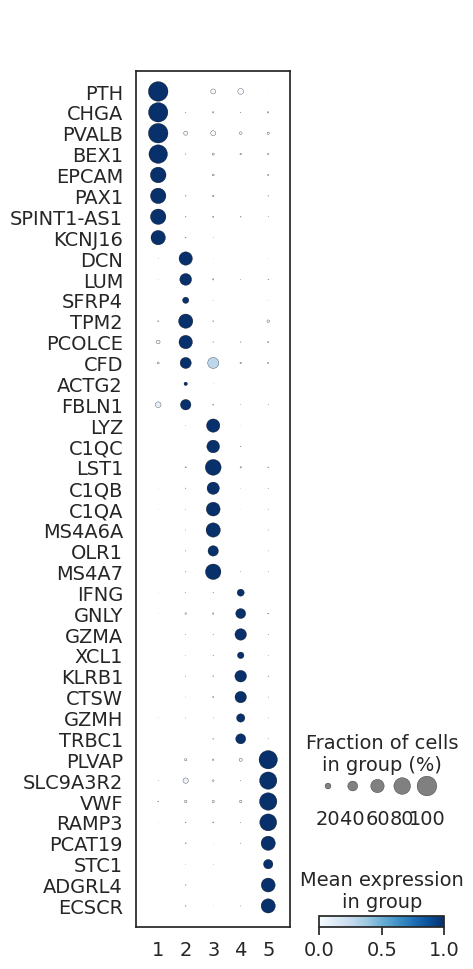

In [41]:
fig, ax =plt.subplots(figsize=(5,10))
axes = sc.pl.dotplot(sdata, groupby='clusters_res_0.1', return_fig=False, ax=ax, swap_axes=True, expression_cutoff=1e-3,
                     var_names=de_gene_set_vis, use_raw=False, standard_scale='var', show=False, cmap='Blues')
axes['mainplot_ax'].set_xticklabels(range(1,6), rotation=0)
plt.tight_layout()

fig.savefig('figures/human_all_cells/markers.png', dpi=500)

In [42]:
sdata.obs['clusters_res_0.1'] = [str(int(x)+1) for x in sdata.obs['clusters_res_0.1'].values]

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


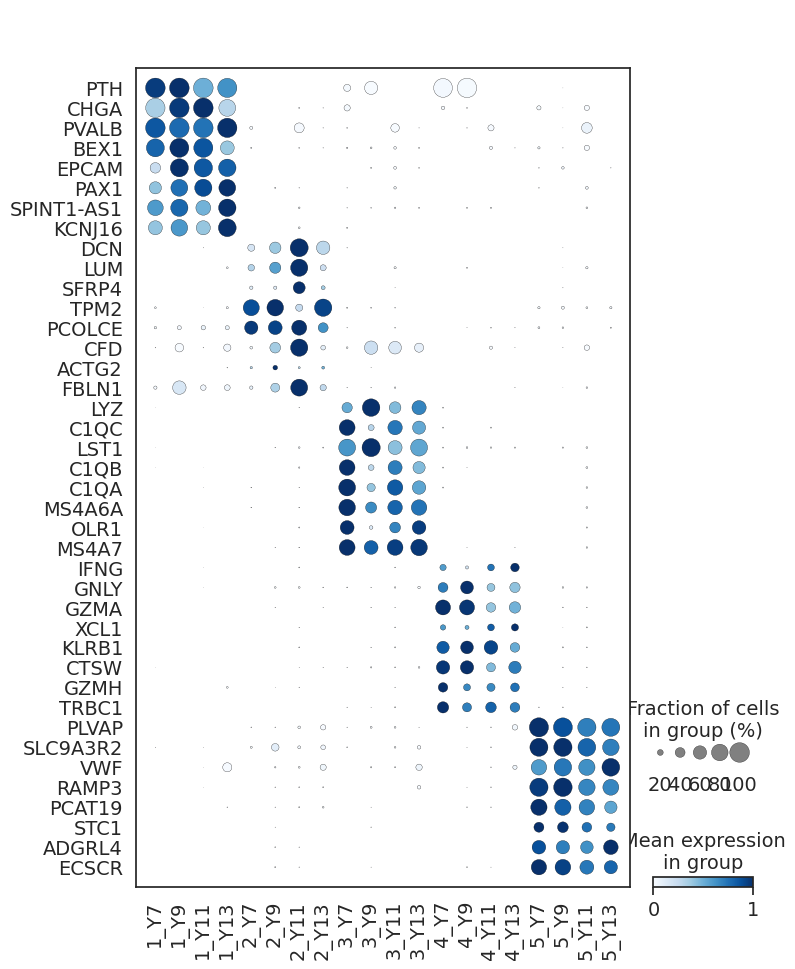

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/utils.py:674: RuntimeWarning: invalid value encountered in log
  log_alpha_hat = np.log(alpha_hat)
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/utils.py:715: RuntimeWarning: invalid value encountered in log
  x0=np.log(alpha_hat),
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/numpy/linalg/linalg.py:2086: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/utils.py:674: RuntimeWarning: invalid value encountered in log
  log_alpha_hat = np.log(alpha_hat)
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/utils.py:715: RuntimeWarning: invalid value encountered in log
  x0=np.log(alpha_hat),
/g

In [43]:
fig, ax =plt.subplots(figsize=(8,10))
axes = sc.pl.dotplot(sdata, groupby=['clusters_res_0.1', 'sample'], return_fig=False, ax=ax, swap_axes=True, expression_cutoff=1e-3,
                     var_names=de_gene_set_vis, use_raw=False, standard_scale='var', show=False, cmap='Blues')
plt.tight_layout()

fig.savefig('figures/human_all_cells/markers_resolved_by_replicate.png', dpi=500)

## DecontX comparison

In [ ]:
predecontx_adata = scanpy.read_h5ad('../data/intermediate_files/1_preprocessed_human_data.h5ad')

# preprocess same as decontaminated counts
predecontx_adata = scprep.normalize.library_size_normalize(predecontx_adata.to_df())
predecontx_adata = scprep.transform.sqrt(predecontx_adata)

In [ ]:
markers = ['PTH', 'COX1', 'COX2', 'GCM2', 'CHGA', 'RARRES2']
for marker in markers:
    fig,ax = plt.subplots(figsize=(5,4))
    ax.set_title(f'{marker}\nPre-DecontX counts by cluster')
    sc.pl.violin(predecontx_adata, keys=marker, groupby='clusters_res_0.1', save=f'_predecontx_primate_{marker}.png', ax=ax, ylabel='expression')
    
    fig,ax = plt.subplots(figsize=(5,4))
    ax.set_title(f'{marker}\nPost-DecontX counts by cluster')
    sc.pl.violin(sdata, keys=marker, groupby='clusters_res_0.1', save=f'_postdecontx_primate_{marker}.png', ax=ax, ylabel='expression')

## Genome-scale heatmaps

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


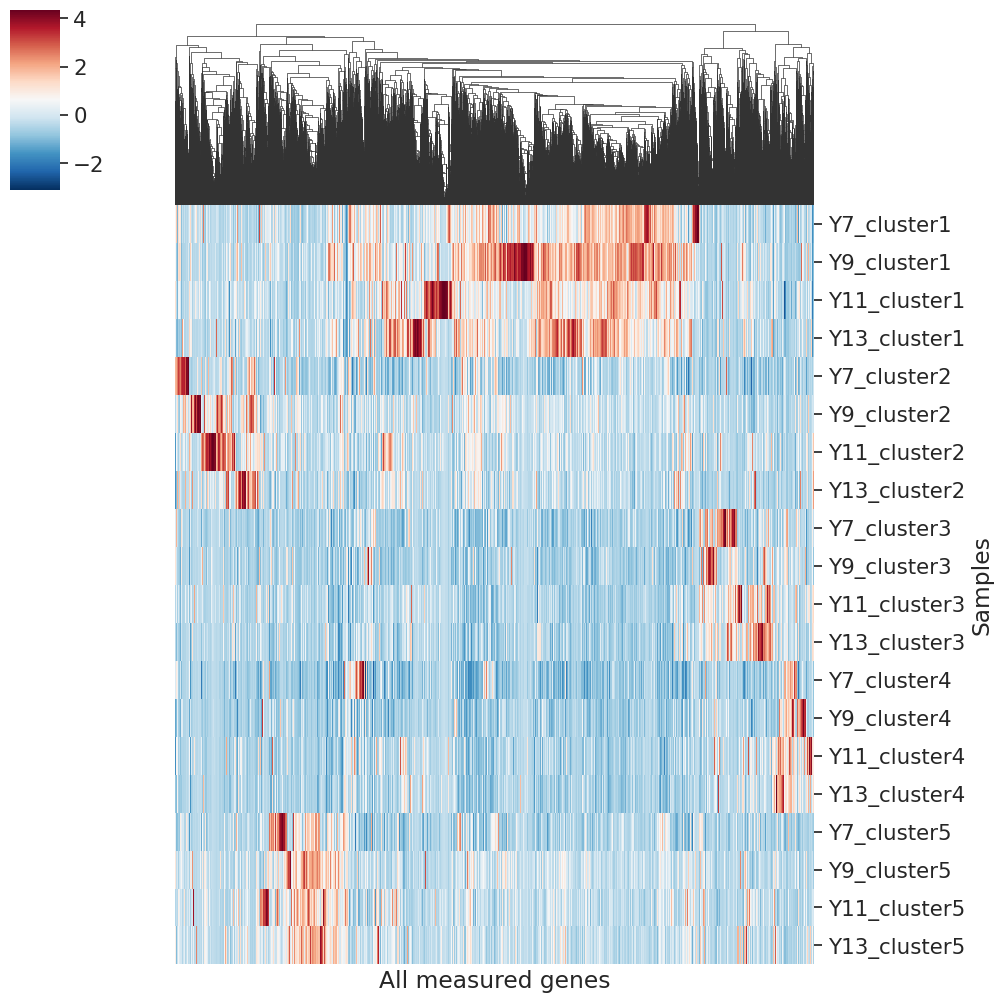

In [53]:
# pre-batch correction

pbs = []
names = []
for cluster in [1,2,3,4,5]:
    for sample in sdata.obs['sample'].unique():
        sdata_subset = sdata[sdata.obs['sample'] == sample]
        samp_cell_subset = sdata_subset[sdata_subset.obs['clusters_res_0.1'] == str(cluster)]

        rep_adata = sc.AnnData(X = samp_cell_subset.X.mean(axis=0), var=samp_cell_subset.var[[]])
        rep_adata.obs['sample'] = sample
        rep_adata.obs['cluster'] = int(cluster)
        names.append(f'{sample}_cluster{cluster}')
        pbs.append(rep_adata)

pb = sc.concat(pbs)
pb.obs_names = names
pb.X = scale(pb.X)

g= sc.pl.clustermap(pb, row_cluster=False, col_cluster=True, figsize=(10,10), show=False, cmap='RdBu_r', xticklabels=False)
ax = g.ax_heatmap
ax.set_xlabel("All measured genes")
ax.set_ylabel("Samples")
g.savefig('figures/human_all_cells/clustermap_human_genome_scale_heatmap.png')

Running MAGIC with `solver='exact'` on 19528-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
Calculating imputation...


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculated imputation in 347.00 seconds.


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a

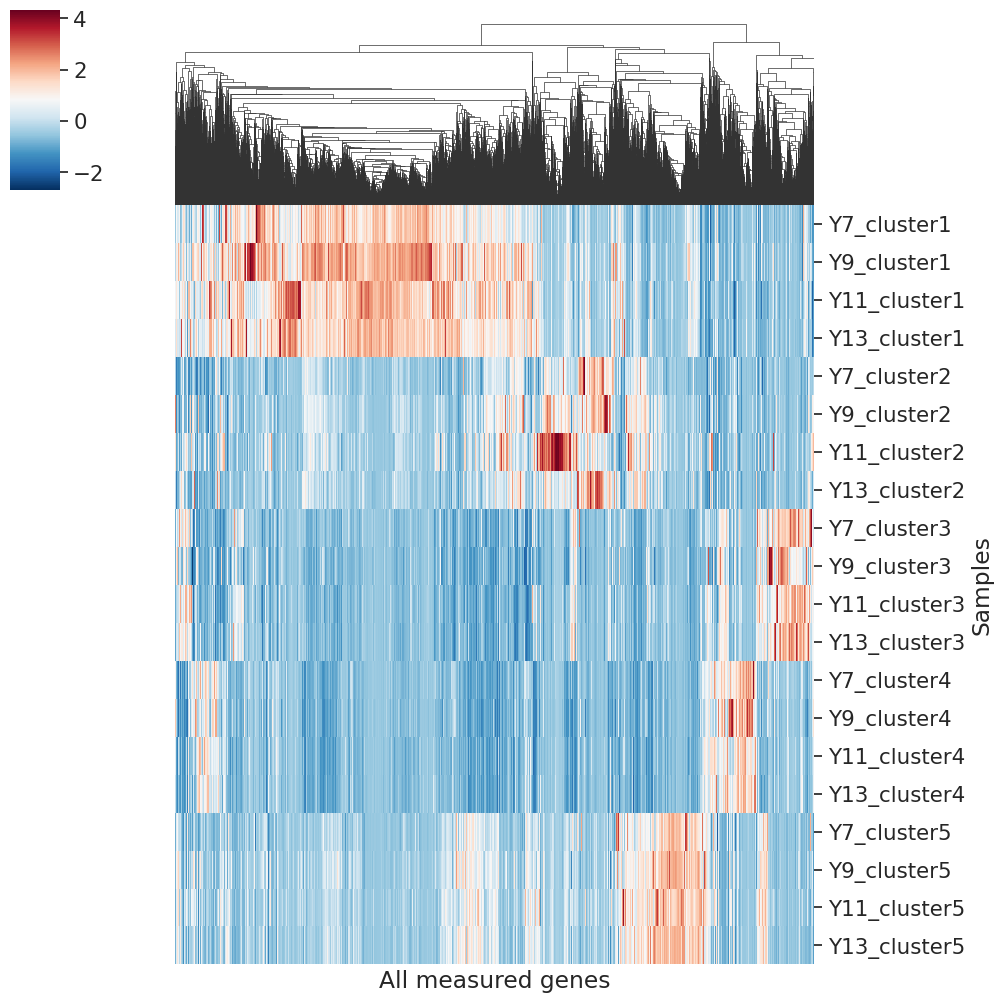

In [54]:
# post-batch correction
# magic simulates changing counts based on new graph (which was used to embed points with PHATE)

magic_op = magic.MAGIC(random_state=42, t=1)
magic_op.graph = G
sdata.layers['X_magic'] = magic_op.transform(sdata.to_df().values, ) 

pbs = []
names = []
for cluster in [1,2,3,4,5]:
    for sample in sdata.obs['sample'].unique():
        sdata_subset = sdata[sdata.obs['sample'] == sample]
        samp_cell_subset = sdata_subset[sdata_subset.obs['clusters_res_0.1'] == str(cluster)]
        samp_cell_subset.X = samp_cell_subset.layers['X_magic']

        rep_adata = sc.AnnData(X = samp_cell_subset.X.mean(axis=0), var=samp_cell_subset.var[[]])
        rep_adata.obs['sample'] = sample
        rep_adata.obs['cluster'] = int(cluster)
        names.append(f'{sample}_cluster{cluster}')
        pbs.append(rep_adata)

pb = sc.concat(pbs)
pb.obs_names = names
pb.X = scale(pb.X)

g= sc.pl.clustermap(pb, row_cluster=False, col_cluster=True, figsize=(10,10), cmap='RdBu_r', xticklabels=False, show=False)
ax = g.ax_heatmap
ax.set_xlabel("All measured genes")
ax.set_ylabel("Samples")
g.savefig('figures/human_all_cells/clustermap_human_bc_genome_scale_heatmap.png')

## Get PTH only

In [80]:
pth = sdata[sdata.obs['clusters_res_0.1'] == '1']
pth.write('../data/intermediate_files/4_human_parathyroid_cells_all_genes.h5ad')

/home/aarthivenkat/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
